# Defining Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import array
from scipy.spatial import distance
from scipy import stats
from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist
from scipy.spatial.distance import mahalanobis
from dtw import dtw
from fastdtw import fastdtw
import time

In [2]:
# audio input when a code finishes running
## Import up sound alert dependencies
from IPython.display import Audio, display

def allDone():
  display(Audio(url="http://www.wavsource.com/snds_2018-01-14_3453803176249356/movies/star_wars/alerted.wav", autoplay=True))
## Insert whatever audio file you want above

# Defining inputs and making data manipulations for the algorithm

In [3]:
################ Inputs ###########################

# Location of input file
enroll_df=pd.read_csv("C:/Users/varun.mohankumar/OneDrive - Ogilvy/Geometry/client/client_hist_enrollments.csv")

# Enter the minimum no of required matches between test and control rows. Usually the # of pre period months are chosen
minimum_matched_pair=3

# enter the required # of best control stores to be matched with test stores. 3 is ideal for reducing error in accuracy  
bestn=3
#####################################################



###### Data manipulations before runnning the algorithm ################

# Data manipulation on the index on which test and control comparison is performed. Location no is the store #
enroll_df['location_no']=enroll_df['location_no'].astype(str)


# Enrollment of Geometry stores
enroll_gs_df=enroll_df[enroll_df['Station_Type']=='GS'].drop(['Station_Type','State','WS','DMA','location_street_address','Fri','Sat','Sun','Mon','Tue','Wed','Thu','12-17','01-18','02-18','03-18'],axis=1).sort_values('location_no',ascending=True)
#Enrollment of Non-Geometry Stores
enroll_ngs_df=enroll_df[enroll_df['Station_Type']=='NGS'].drop(['Station_Type','State','WS','DMA','location_street_address','Fri','Sat','Sun','Mon','Tue','Wed','Thu','12-17','01-18','02-18','03-18'],axis=1).sort_values('location_no',ascending=True)

#Filtering data for minimum pair matches. Stores having data less than the minimum # (matches) monthly datapoints are eliminated
enroll_gs_df['cnt']=(enroll_gs_df>0).sum(1)-1
enroll_ngs_df['cnt']=(enroll_ngs_df>0).sum(1)-1
enroll_gs_df_fin=enroll_gs_df[enroll_gs_df['cnt']>minimum_matched_pair].drop(['cnt'],axis=1)
enroll_ngs_df_fin=enroll_ngs_df[enroll_ngs_df['cnt']>minimum_matched_pair].drop(['cnt'],axis=1)

# Before filter
print("Before Filter: Test-",len(enroll_gs_df)," Control-",len(enroll_ngs_df))

# After filter
print("After Filter: Test-",len(enroll_gs_df_fin)," Control-",len(enroll_ngs_df_fin))

# Stores eliminated from Test list
enroll_gs_df[~enroll_gs_df.isin(enroll_gs_df_fin['location_no'])].dropna()
########################################################################################

Before Filter: Test- 359  Control- 13258
After Filter: Test- 354  Control- 12921


,location_no,01-16,02-16,03-16,04-16,05-16,06-16,07-16,08-16,09-16,...,03-17,04-17,05-17,06-17,07-17,08-17,09-17,10-17,11-17,cnt
213,10014844,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
317,12575260,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
293,12577207,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,92,1
357,12597381,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
318,12609811,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,148,1


# VnD Time series Similarity algorithm - 

In [4]:
################# Time series Similarity measure Algorithm #################

#Timing the algorithm
start_time = time.time()

# Creating Test and control arrays for algorithm from Test and control dataframes
test_arr=enroll_gs_df_fin.iloc[:,1:].values
control_arr=enroll_ngs_df_fin.iloc[:,1:].values

##### Defining the length of arrays 
# number of test anf control stores
test_len=len(test_arr)
control_len=len(control_arr)
# max length of the time series
tseries_len=len(test_arr[0])
matrix_dim=(test_len,control_len)

# Defines the starting point (month) from which each datapoint for each store starts in the time series 
test_start_val=np.zeros(test_len,dtype=int)
control_start_val=np.zeros(control_len,dtype=int)

# The new arrays will have Null values for non existing data
test_arr_n=np.zeros((test_len,tseries_len))
control_arr_n=np.zeros((control_len,tseries_len))

# Replacing the initials time periods where data did not exist as NaN. Usually used when the time period when the stores was started changes
#test stores replacement
for i in range(test_len):
    cumsum=test_arr[i][0]
    for k in range(tseries_len):
        if cumsum>0:
            test_arr_n[i][k-1]=test_arr[i][k-1]
        else:
            cumsum=cumsum+test_arr[i][k]
            test_arr_n[i][k-1]=np.NaN
            test_start_val[i]=k
    test_arr_n[i][k]=test_arr[i][k]  

#Control stores replacement
for j in range(control_len):
    cumsum=control_arr[j][0]
    for k in range(tseries_len):
        if cumsum>0:
            control_arr_n[j][k-1]=control_arr[j][k-1]
        else:
            cumsum=cumsum+control_arr[j][k]
            control_arr_n[j][k-1]=np.NaN
            control_start_val[j]=k
    control_arr_n[j][k]=control_arr[j][k]     

# Creating the Matrix with measures that compares the test and control stores which is later used to evaluate the best match
#rows are test and columns are control
# My algorithm measures
distance_mat=np.empty(matrix_dim)
variance_mat=np.empty(matrix_dim)

# Time Warping algorithm measures
dist_dtw_mat=np.empty(matrix_dim)
lag_mat=np.empty(matrix_dim)

for i in range(test_len):
    for j in range(control_len):#control_len
        # Equalizing the start of series comparison for possible, null values or unmatched start of time between test and control
        tseries_start_pt=max(test_start_val[i],control_start_val[j])
        test_series=test_arr_n[i][tseries_start_pt:]
        control_series=control_arr_n[j][tseries_start_pt:]
    
    
        # Creating cordinates for every point in the time series and then make a comparison
        tindex = np.arange(0,len(test_series)).reshape(-1,1)
        cindex = np.arange(0,len(control_series)).reshape(-1,1)
        tindex = np.arange(0,len(test_series)).reshape(-1,1)
        cindex = np.arange(0,len(control_series)).reshape(-1,1)
        t1 = test_series.reshape(-1, 1)
        c1 = control_series.reshape(-1, 1)
        t2d = np.hstack((tindex,t1 ))
        c2d = np.hstack((cindex,c1 ))


# Creating the distance and variance matrix for it to be compared later    
        distance_mat[i][j]=round(np.sum(np.diagonal(distance.cdist(t2d,c2d,'mahalanobis'))),3)
        variance_mat[i][j]=round(np.var(np.diagonal(distance.cdist(t2d,c2d,'mahalanobis'))),3)
        

#-------------------------------------------------------------------------------------------------
# the problem with DTW is that it almost always gives the the trend typea similar but it is lagged or leaded
# hence DTW cannot be used for the case of this client. But it will find other interesting applications in other time series analysis 
# for future use keep this code 
#-----For future creation, using lag matrix: first create the distance,variance and lag matrix, run thru the lag matrix, check for lags and overwrite on distance and variance
#@@         dist, cost, acc, path = dtw(t1, c1, dist=euclidean)
#@@         dist_dtw_mat[i][j], path = fastdtw(t1, c1, dist=euclidean)
#@@         mode=stats.mode(np.diff(path,axis=0),axis=None)
#@@         lag_mat[i][j]=array(mode[0])

# reference: http://alexminnaar.com/time-series-classification-and-clustering-with-python.html
#         DTW basically calc. the distance of every point in the time series with every other point in comparison time series and gets the minimized set
#-------------------------------------------------------------------------------------------------


# Calculating and Printing the final result

test_header_array=enroll_gs_df_fin['location_no'].values
control_header_array=enroll_ngs_df_fin['location_no'].values
variance_df=pd.DataFrame(data=variance_mat,index=test_header_array,columns=control_header_array)

# creating the index and columns for output array
idx=test_header_array
cln=control_header_array

# The final returns the indexes of sorted values. A huge sorted array is created (lowest to highest variance) and the first n  columns are filtered based on the request. 
min_val_array=variance_mat.argsort(axis=1)[:,:bestn]


# Creating the structure of results array by looping through min val array, to return the actual control store names
result=[]
for i in range(len(idx)):
    listtemp=[]
    for j in range(bestn):
           listtemp.append(cln[min_val_array[i][j]])
    result.append(listtemp)

            
result_array=np.array(result)

# Creating the output data frame
result_df=pd.DataFrame(data=result_array,index=idx,columns=np.arange(1,bestn+1))
print(result_df)
result_df.to_csv("control_store_list.csv")


print("--- %s seconds ---" % (time.time() - start_time))    
##################################################################################################

#Notification to say that the code is complete
allDone()      

                 1         2         3
10000254  10071491  10084799  12589641
10000291  10051904  10010213  10014345
10000292  12574476  10011835  12589641
10000295  10009827  10013361  10007882
10000296  10014009  10087060  10015513
10000299  10003471  10009386  10013226
10000301  10011210  12592288  12546661
10000302  10000308  10007771  10007882
10000303  10047148  10000653  12479950
10000305  12589641  10006245  12567200
10000306  10005799  10087012  10015303
10000309  10001245  12544374  10090237
10000310  10000256  10000260  10047729
10001380  10087016  10070929  12458071
10004431  12592288  10090237  10012092
10004438  12588416  10001199  12590149
10004459  12579359  12486941  12592927
10004598  12592288  10012092  10012097
10004698  10051416  10047151  10072072
10004699  10056245  12570770  10011744
10004712  10004019  10003113  10007409
10004892  12585410  12576342  10071440
10004947  10007409  10002235  12570770
10004950  10009378  10008128  10012156
10004999  12567200  10055

# 354*12921= 4.5 Million iterations

# Plotting the output for visual interpretation

In [5]:
# Data manipulation for plots
enroll_gs_df.set_index(['location_no'],inplace=True)
enroll_gs_plot_df=enroll_gs_df.T
enroll_gs_plot_unstk_df=enroll_gs_plot_df.stack().reset_index().rename(columns={'level_0':'mnths','State':'row_num'})
enroll_ngs_df.set_index(['location_no'],inplace=True)
enroll_ngs_plot_df=enroll_ngs_df.T
enroll_ngs_plot_unstk_df=enroll_ngs_plot_df.stack().reset_index().rename(columns={'level_0':'mnths','State':'row_num'})
enroll_gs_plot_df=enroll_gs_plot_df.drop('cnt',axis=0)
enroll_ngs_plot_df=enroll_ngs_plot_df.drop('cnt',axis=0)

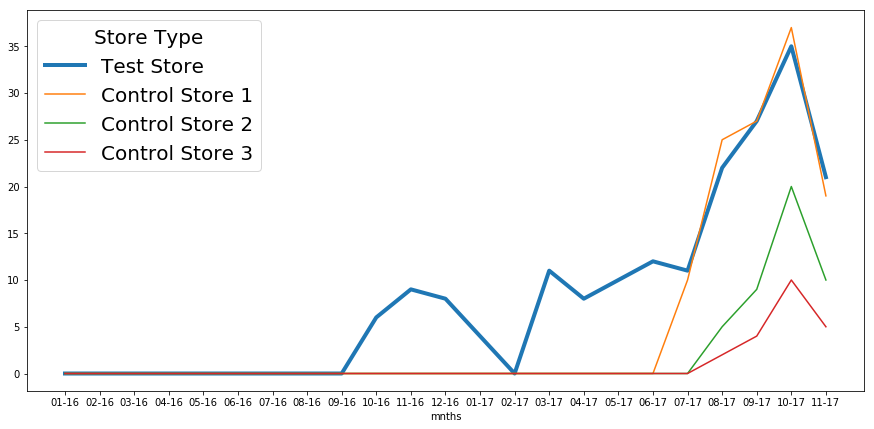

In [8]:
# Plot Test and control by months to validate the functionality of similarity measure.

ax=enroll_gs_plot_df['12527139'].plot(legend=True,figsize=(15,7), linewidth=4.0, label="Test Store")
ax=enroll_ngs_plot_df['12592927'].plot(legend=True,figsize=(15,7), label="Control Store 1")

#-- Use it for multiple line graph plots on the same chart, if necessary

ax=enroll_ngs_plot_df['12592681'].plot(legend=True,figsize=(15,7), label="Control Store 2")
ax=enroll_ngs_plot_df['12570770'].plot(legend=True,figsize=(15,7), label="Control Store 3")
leg=ax.legend(title="Store Type",fontsize=20)
leg.get_title().set_fontsize('20')
# ax=enroll_ngs_plot_df['10000337'].plot(legend=True,figsize=(15,7))
# ax=enroll_ngs_plot_df['10000297'].plot(legend=True,figsize=(15,7))


xaxis=array(enroll_gs_plot_unstk_df['mnths'].unique().tolist())
plt.xticks(np.arange(0, 23, step=1))
ax.set_xticklabels(xaxis)
ax.set_xlabel('mnths')
plt.show()


In [333]:
# Combos of Test and control checked

#12585404: 10012757,10008908,10004994
#10000254:  10071491  10084799  12589641
#10000310: 10000256  10000260  10047729
#10004459:  12579359  12486941  12592927
#10004699  10056245  12570770  10011744
#12477460:  10087220  12585357  12574014
#10004431:  12592288  10090237  10012092
#12527139:  12592927  12592681  12570770
#12528037:  10007418  12478535  10087336
#12577201  10013174  12448033  12413795
#12581540  10048531  10089594  10056951
#12530121:  10007418  12481614  10008626
# 10000299  10003471  10009386  10013226   
# 12457598  10009590  10071483  10006131
# 12507651:  12589783  12589784  12600630

#Another good example is this  12575779:  10010481  10000315  10004770


# Screw up combos(test,control): 10004699,10011744

result_df

,1,2,3
10000254,10071491,10084799,12589641
10000291,10051904,10010213,10014345
10000292,12574476,10011835,12589641
10000295,10009827,10013361,10007882
10000296,10014009,10087060,10015513
10000299,10003471,10009386,10013226
10000301,10011210,12592288,12546661
10000302,10000308,10007771,10007882
10000303,10047148,10000653,12479950
10000305,12589641,10006245,12567200


## Other Discussion points
###### some match types start only from the last 3 months cuz of the pre period time, Hence 5 stores are ignored from test
###### 2nd and 3rd best might become interchangeable
###### Taking an average/sum by month for control stores can be done, After aggregating by months do a  graph check for control Vs test. If it matches properly atleast for the last 3 months then it is good.
###### Check for Test-control/control again must be (1+ test/1+control )-1 , FInalize on whichever method client is comfy

# Results check and Rough work starts here 

In [282]:
# ind = np.argpartition(variance_mat,range(2))[:2,:]
# print(ind)
# print(variance_mat[ind],variance_mat[ind].shape,variance_mat[ind][0])
#print(variance_mat.argsort(axis=1)[:,:5].shape,variance_mat.argsort(axis=1)[:,:5])
#print(np.amin(variance_mat,axis=1),np.argmin(variance_mat,axis=1))
# vdistance_mat=distance_mat
# vvariance_mat=variance_mat
# print(np.amin(variance_mat,axis=1),np.argmin(variance_mat,axis=1))
print(variance_mat.argsort(axis=1)[:,:5].shape,variance_mat.argsort(axis=1)[:,:5])
variance_mat

(354, 5) [[6460 8607 8608 8609 8610]
 [6460 8607 8608 8609 8610]
 [6460 8607 8608 8609 8610]
 ...
 [6460 8607 8608 8609 8610]
 [6460 8607 8608 8609 8610]
 [6460 8607 8608 8609 8610]]


array([[1.982, 0.521, 0.999, ..., 0.   , 0.   , 0.   ],
       [2.022, 1.486, 1.761, ..., 0.   , 0.   , 0.   ],
       [1.445, 1.394, 0.315, ..., 0.   , 0.   , 0.   ],
       ...,
       [0.368, 0.839, 0.794, ..., 0.   , 0.   , 0.   ],
       [0.861, 0.99 , 0.913, ..., 0.   , 0.   , 0.   ],
       [0.542, 0.686, 0.319, ..., 0.   , 0.   , 0.   ]])

In [97]:
test_header_array

array(['10000254', '10000291', '10000292', '10000295', '10000296',
       '10000299', '10000301', '10000302', '10000303', '10000305',
       '10000306', '10000309', '10000310', '10001380', '10004431',
       '10004438', '10004459', '10004598', '10004698', '10004699',
       '10004712', '10004892', '10004947', '10004950', '10004999',
       '10005038', '10005064', '10005076', '10005151', '10005158',
       '10005363', '10005423', '10005424', '10005552', '10005592',
       '10005802', '10005821', '10005826', '10005842', '10005884',
       '10005892', '10005920', '10005961', '10005964', '10005970',
       '10005972', '10005978', '10005986', '10006032', '10006052',
       '10006101', '10006110', '10006156', '10006157', '10006185',
       '10006203', '10006209', '10006227', '10006256', '10006265',
       '10006278', '10006287', '10006344', '10006426', '10007357',
       '10007372', '10007411', '10007625', '10007636', '10007716',
       '10007775', '10007785', '10007833', '10007834', '100078

In [370]:
# print(distance_mat,variance_mat,lag_mat)
#print(test_arr_n[15])
# print(test_series) #last record in test
# print(control_series)

# 32:'10000297' V:0.5 D:13.503 Ddtw:939 a little F up, directs us to use distance as a metric
# 8:'10000263' V:0.38 D:7.107 ddtw:238 Decent 
# 58:'10000337' V:0.329 D:12.847  ddtw:328 good
# 35:'10000308' V 0.29 D:13.682 ddtw:645 Vgood
# 95:10000446 V:0.495 D:12.922 ddtw:513 seems better than 8
# 193:10000591 V 0.459 D:16.277 not as goos as 8 also
# print(variance_mat[0][0:1000])
# print("Next")
# print(distance_mat[0][0:1000])
print(dist_dtw_mat[0][0:100])

[ 461.  332.  498.  320.  292.  511.  338.  238.  408.  498.  444.  492.
  532.  467.  504.  439.  457.  441.  464.  481.  428.  385.  556.  392.
  407.  548.  498.  461.  513. 1660.  497.  939.  413.  425.  645. 1026.
  456. 1031.  336.  517.  469.  502.  460.  539.  452.  558.  476.  494.
  507.  508.  446.  519.  526.  529.  557.  525.  450.  328.  435.  528.
  411.  483.  481.  476.  550.  507.  621.  465.  458.  559.  462.  494.
  462.  508.  472.  419.  446.  553.  503.  475.  464.  373.  338.  461.
  474.  424.  333.  397.  552.  480.  455.  503.  377.  414.  169.  454.
  348.  513.  460.  431.]


In [121]:
enroll_ngs_df_fin['location_no'].iloc[5126]

'10010515'

In [118]:
# Max of control_start_val and test_start_val should be used

control_arr_n[10][max(test_start_val[10],control_start_val[10]):]
# max(test_start_val[10],control_start_val[10])


array([ 4.,  8.,  8.,  2.,  4.,  4., 12., 11.,  3.,  2.,  7., 11.,  4.,
        8., 17., 10., 15., 21., 12., 24., 25., 19.])

In [242]:
# print((test_arr_n[15]))
print((test_arr[15]))
# print(test_start_val[15])
print(test_start_val)
print(control_start_val[0:19])

[ 0  0  0  0  0  0  0 16 11  4  1  8 12  8 18  9  7 31 17 23 19 12 26]
[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7  0  0  0  0  0  0  3  0
  0  3  3  0  0  5  3  3  3  0  3  0  0  0  5  0  0  6  0  0  0  0 18 18
  0  6  0  0  0  0  8  0  0  0  0  0  0  0  0  1  0  8  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  4  6  9  0  0  0  0  0 11  3  4  1  4  0  0
  0  0  0  0  4  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  7
  0  0  0  0  0  0  0  4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  3  3  7  3  3  3  3
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  4  0 19  0  0  3  3
  3  0  0  0  0  3  0  0  0  0  8  0  0  0  0  0  0  0  0  2  0  0  0  0
  0  0  0  3  0  0  0  0  0  0  0  0  1  0  1  0  0  6  0  0  0  0  2  9
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  4  0
  0  0  0  0  0  0  1  0  0  0  0  5  3  0  5  0  0  

In [251]:
print((control_arr_n[11]))
print((control_arr[11]))


[ 1.  1.  2.  3.  1.  0.  0.  1.  2.  1.  3.  2.  3.  3.  3.  5.  4. 22.
  3.  4. 11.  9. 11.]
[ 1  1  2  3  1  0  0  1  2  1  3  2  3  3  3  5  4 22  3  4 11  9 11]


In [116]:
test_arr_n

array([[  3.,   7.,  12., ..., 166.,  17.,  19.],
       [ 10.,   5.,  12., ..., 880.,  14.,  24.],
       [  8.,  10.,  23., ...,  37.,  39.,  22.],
       ...,
       [ nan,  nan,  nan, ...,  11.,   7.,   7.],
       [ nan,  nan,  nan, ...,  nan,  nan,   0.],
       [ nan,  nan,  nan, ...,  nan,  nan, 148.]])

In [119]:
enroll_gs_df['cnt']= enroll_gs_df.apply(lambda x: (x>0).count(), axis=1)

In [211]:
enroll_gs_df['cnt']=(enroll_gs_df.apply(pd.to_numeric,errors='coerce')>0).astype(int).sum(axis=1)
#enroll_gs_df['cnt']=(enroll_gs_df>0).sum(1)-1
# enroll_df.dtypes

In [200]:
enroll_gs_df['cnt']

173    25
162    25
199    25
200    25
174    25
269    25
282    25
168    25
268    25
266    22
278    25
275    25
283    25
175    25
251    25
56     18
228    25
216    25
169    25
176    25
108    25
331    25
90     22
152    25
139    23
190    21
191    22
242    25
219    25
347    19
       ..
89     17
104    21
302    13
311    17
309    16
198    19
3      18
294    14
182    15
117    13
138    13
42     12
315    15
312    14
306    14
303    14
314    14
307    14
301    13
317     2
156     6
308     7
304     7
293     3
123    10
2       8
67      7
330     7
357     2
318     3
Name: cnt, Length: 359, dtype: int64

In [14]:
enroll_ngs_df_fin

,location_no,01-16,02-16,03-16,04-16,05-16,06-16,07-16,08-16,09-16,...,02-17,03-17,04-17,05-17,06-17,07-17,08-17,09-17,10-17,11-17
6317,10000253,7,7,4,6,17,10,4,3,10,...,12,13,7,11,16,6,9,7,20,17
8284,10000256,8,10,9,6,6,5,4,10,8,...,5,8,9,9,56,165,183,85,65,69
6263,10000257,15,17,15,9,14,14,10,22,26,...,15,23,22,17,56,60,68,62,35,39
8323,10000258,12,17,10,6,10,9,6,10,9,...,7,10,9,11,51,99,28,16,14,10
8281,10000260,8,11,9,4,8,12,4,4,8,...,6,0,2,4,90,196,182,142,54,68
8283,10000261,9,11,13,11,11,10,14,14,14,...,15,18,10,5,190,391,261,178,65,109
6258,10000262,7,5,3,4,5,5,4,9,6,...,11,5,11,4,27,14,79,42,19,19
8295,10000263,10,15,13,6,6,3,6,6,7,...,1,2,6,2,28,144,162,103,10,6
6261,10000264,8,10,12,6,6,12,7,8,12,...,3,12,3,9,24,19,22,23,27,18
6369,10000266,4,0,9,6,6,6,2,2,13,...,2,4,4,5,10,3,9,2,6,9
